In [4]:
%load_ext autoreload
%autoreload 2

**Downloading pretrained GPT2 model**

In [ ]:
from transformers.modeling_gpt2 import GPT2LMHeadModel
# This downloads GPT-2 Medium, it takes a little while
_ = GPT2LMHeadModel.from_pretrained("gpt2-medium")

**Imports**

In [6]:
import math
from typing import List

import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
from transformers import (GPT2Tokenizer, OpenAIGPTLMHeadModel,
                          OpenAIGPTTokenizer)
from transformers.modeling_gpt2 import GPT2LMHeadModel

from dist import eval_distinct
from run_pplm import run_pplm_example
from run_pplm_simple_text import postprocess_pplm_output, pplm_loss

from IPython.display import display, HTML

**Running a test example**

In [1]:
from run_pplm import run_pplm_example

In [ ]:
run_pplm_example(
    cond_text="The potato",
    num_samples=10,
    bag_of_words='military',
    length=10,
    stepsize=0.03,
    sample=True,
    num_iterations=3,
    window_length=5,
    gamma=1.5,
    gm_scale=0.95,
    kl_scale=0.01,
    colorama = True,
    verbosity='regular'
)

**Evaluation Metrics**

*Perplexity (ppl)*

In [14]:
def compute_ppl(sent):
    indexed_tokens = ppl_tokenizer.encode(sent)
    tokens_tensor = torch.tensor([indexed_tokens])
    tokens_tensor = tokens_tensor.to(device)
    with torch.no_grad():
        outputs = ppl_model.forward(tokens_tensor, labels=tokens_tensor)
    loss = outputs[0]
    return math.exp(loss.item())

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:1" if use_cuda else "cpu")
print(device)

ppl_tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
ppl_model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
ppl_model.to(device)
_ = ppl_model.eval()


cuda:1


ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
PPLM_TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2-medium")

In [15]:
import re

def clean_text(t):
    t = t.replace('<|endoftext|>', '')
    t = re.sub('\s{1,}', ' ', t)
    return t


def evaluate(samples):
    df = pd.DataFrame({
        'text': [clean_text(sample) for sample in samples]
    })
    df['ppl'] = df['text'].apply(compute_ppl)
    dist = df['text'].apply(lambda text: eval_distinct([text], PPLM_TOKENIZER))
    df[['dist-1', 'dist-2', 'dist-3']] = pd.DataFrame(dist.tolist())
    df['dist'] = dist.apply(np.mean)
    
    return df

**Generate 5 samples each for 31 prompts for 400 hyperparameter configurations**

Generate samples for all prompts and write to CSV file for further analysis.

```sh
conda activate pplm
mkdir -p data/

python hyperparameter-analysis.py --start 0 --end 400 --device cuda:0
```

**Generating average of all generated texts over the evaluation metric perplexity (ppl) and distinctiveness (dist) for each hyperparameter configuration**

In [ ]:
import glob

filenames_allprompts = glob.glob('hyperparameter-files/allprompts*.csv')

In [ ]:
METRICS = [
    'ppl',
    'dist'
]

for i,file in enumerate(filenames_allprompts):
    print("index:",i)
    # Load raw data
    df = pd.read_csv(file, index_col=0)
    df = df[df.index.notnull()].reset_index(drop=True)
    
    # Compute metrics
    df = pd.concat([df, evaluate(df['raw'])], axis=1)
    
    # Split unperturbed/perturbed samples
    df = df[~(df['kind'] == 'unperturbed')]

    df['PPLM objective'] = file.split('/')[1].split('allprompts_')[1].strip('.csv')
    
    if i==0:
        df_combined=df
    else:
        df_combined = pd.concat([df_combined,df], ignore_index=True)
    
    df_agg = df_combined[METRICS + ['PPLM objective']].groupby('PPLM objective').agg(['mean', 'std']).round(2)
    #print(df_agg.head())
df_agg.to_csv('hyperparameter_evaluation_metrics.csv')

**Creating the parallel coordinate plots for evaluation metric - perplexity and distinctiveness (with GM-scale hyperparameter vertical line being closer to the evaluation metric). This is the plot added to the ICLR blog.**

                                     hyperparameters    ppl   ppl.1  dist  \
0  {'stepsize': 0.0, 'kl_scale': 0.0, 'grad_lengt...  100.4  151.45  0.91   
1  {'stepsize': 0.0, 'kl_scale': 0.0, 'grad_lengt...  100.4  151.45  0.91   
2  {'stepsize': 0.0, 'kl_scale': 0.0, 'grad_lengt...  100.4  151.45  0.91   
3  {'stepsize': 0.0, 'kl_scale': 0.01, 'grad_leng...  100.4  151.45  0.91   
4  {'stepsize': 0.0, 'kl_scale': 0.01, 'grad_leng...  100.4  151.45  0.91   

  dist.1  stepsize  kl_scale  grad_length  gm_scale  
0   0.05       0.0      0.00           14       0.4  
1   0.05       0.0      0.00            2       0.4  
2   0.05       0.0      0.00            6       0.9  
3   0.05       0.0      0.01           16       0.7  
4   0.05       0.0      0.01            2       0.8  
Max ppl: 100.4
Min ppl: 51.68
Max dist: 0.91
Min dist: 0.82


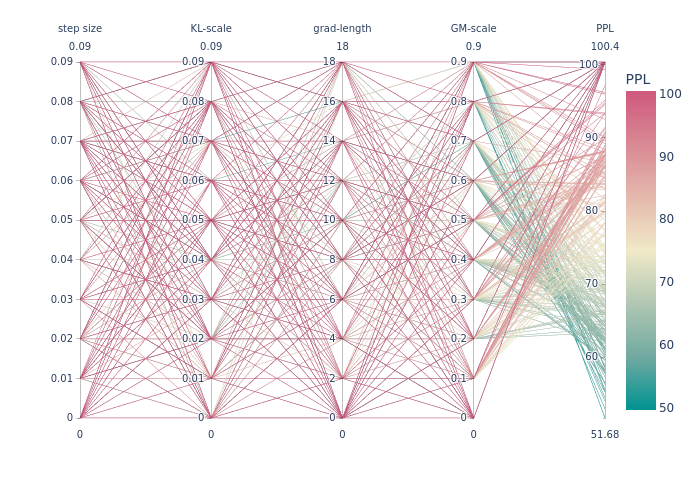

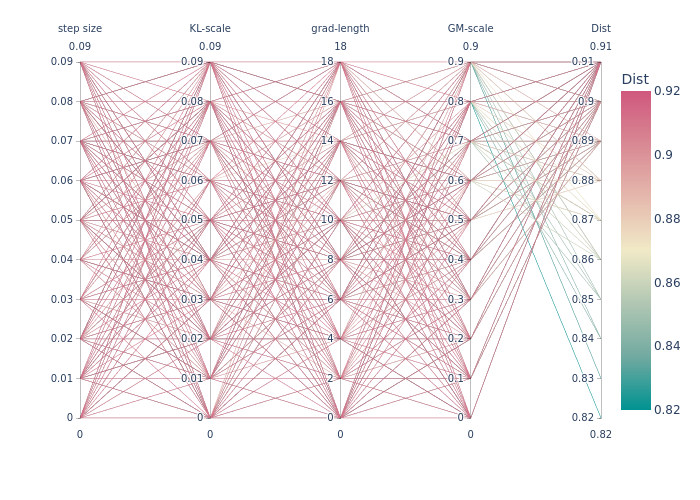

In [145]:
import plotly.express as px
import ast

import plotly.io as pio
from plotly.subplots import make_subplots

file='hyperparameter_evaluation_metrics.csv'
df = pd.read_csv(file, sep=',')
df = df.loc[2:].reset_index(drop=True)
df.rename( columns={'Unnamed: 0':'hyperparameters'}, inplace=True )
hyperparameters_df=pd.DataFrame(df['hyperparameters'].map(lambda d : ast.literal_eval(d)).tolist())
df = pd.concat([df, hyperparameters_df], axis=1)
print(df.head())

df['ppl']=df['ppl'].astype('float64')
print("Max ppl:",max(df['ppl']))
print("Min ppl:",min(df['ppl']))

df['dist']=df['dist'].astype('float64')
print("Max dist:",max(df['dist']))
print("Min dist:",min(df['dist']))

fig = px.parallel_coordinates(df, dimensions=['stepsize','kl_scale','grad_length','gm_scale','ppl'], color="ppl", labels={"stepsize": "step size","kl_scale": "KL-scale", "grad_length": "grad-length","gm_scale": "GM-scale","ppl":"PPL"},color_continuous_scale=px.colors.diverging.Tealrose,color_continuous_midpoint=75)
fig1 = px.parallel_coordinates(df, dimensions=['stepsize','kl_scale','grad_length','gm_scale','dist'], color="dist", labels={"stepsize": "step size","kl_scale": "KL-scale", "grad_length": "grad-length","gm_scale": "GM-scale","dist":"Dist"},color_continuous_scale=px.colors.diverging.Tealrose,color_continuous_midpoint=0.87)

fig.show(renderer="png")
fig1.show(renderer="png")

#fig.write_image("imgs/parallel_coordinate_plot_ppl_gmscale.png")
fig1.write_image("imgs/parallel_coordinate_plot_dist_gmscale.png")

### Extra parallel coordinate plots (not added to the ICLR blogpost) 
#### Re-arranging the hyperparameter vertical lines such that each hyperparameter is once closer to the evaluation metric, such that the effect of that hyperparameter on the evaluation can be prominently seen

**Parallel coordinate plots with step size, KL-scale and grad-length vertical lines respectively being closer to the evaluation metric - perplexity**

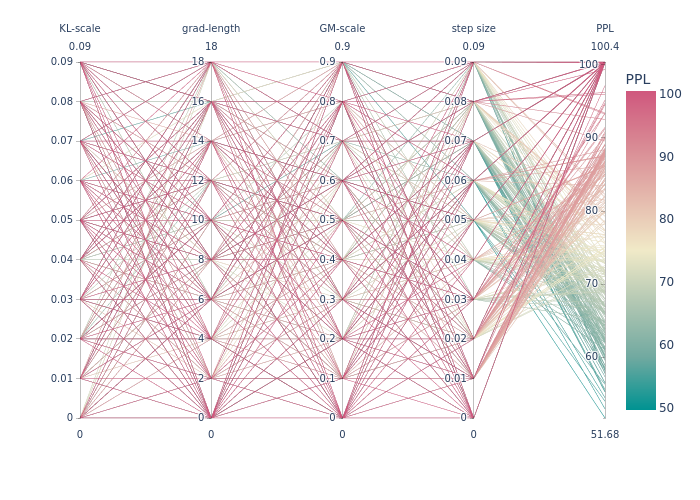

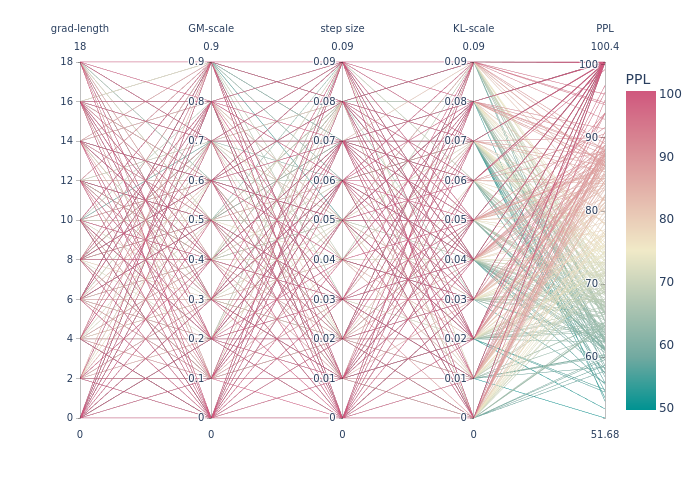

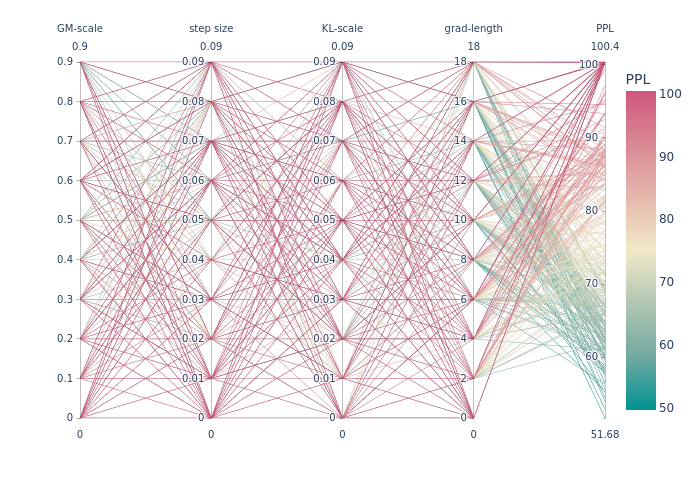

In [143]:
fig1 = px.parallel_coordinates(df, dimensions=['kl_scale','grad_length','gm_scale','stepsize','ppl'], color="ppl", labels={"stepsize": "step size","kl_scale": "KL-scale", "grad_length": "grad-length","gm_scale": "GM-scale","ppl":"PPL"},color_continuous_scale=px.colors.diverging.Tealrose,color_continuous_midpoint=75)
fig2 = px.parallel_coordinates(df, dimensions=['grad_length','gm_scale','stepsize','kl_scale','ppl'], color="ppl", labels={"stepsize": "step size","kl_scale": "KL-scale", "grad_length": "grad-length","gm_scale": "GM-scale","ppl":"PPL"},color_continuous_scale=px.colors.diverging.Tealrose,color_continuous_midpoint=75)
fig3 = px.parallel_coordinates(df, dimensions=['gm_scale','stepsize','kl_scale','grad_length','ppl'], color="ppl", labels={"stepsize": "step size","kl_scale": "KL-scale", "grad_length": "grad-length","gm_scale": "GM-scale","ppl":"PPL"},color_continuous_scale=px.colors.diverging.Tealrose,color_continuous_midpoint=75)
fig1.show(renderer="png")
fig2.show(renderer="png")
fig3.show(renderer="png")

**Parallel coordinate plots with step size, KL-scale and grad-length vertical lines respectively being closer to the evaluation metric - distinctiveness**

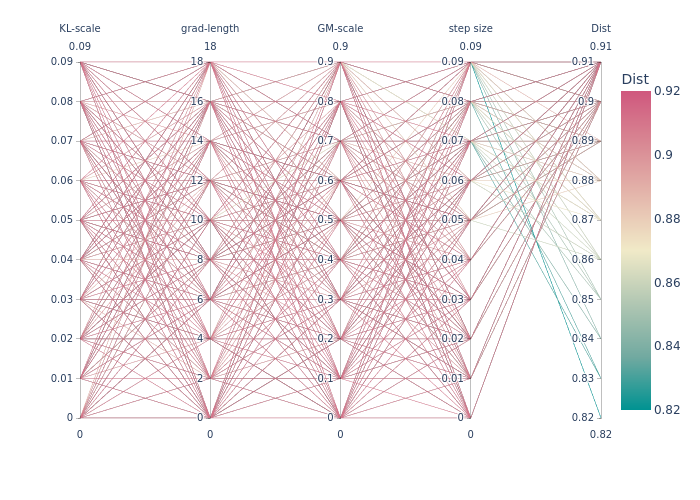

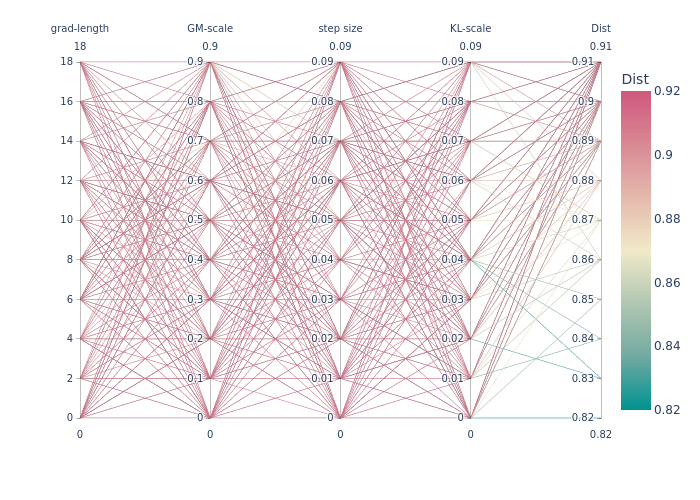

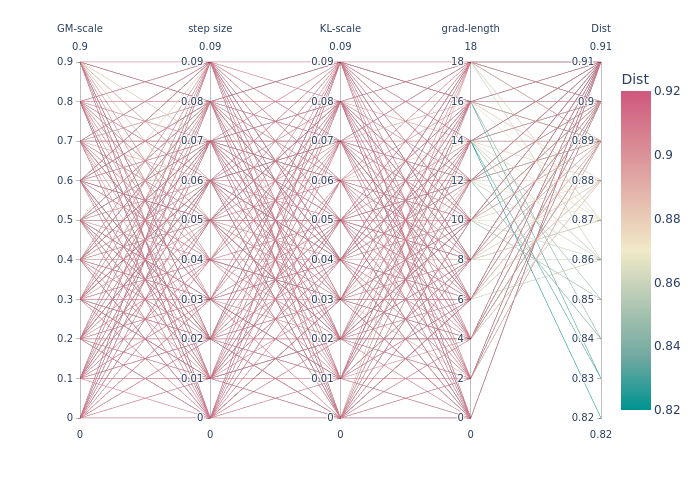

In [146]:
fig1 = px.parallel_coordinates(df, dimensions=['kl_scale','grad_length','gm_scale','stepsize','dist'], color="dist", labels={"stepsize": "step size","kl_scale": "KL-scale", "grad_length": "grad-length","gm_scale": "GM-scale","dist":"Dist"},color_continuous_scale=px.colors.diverging.Tealrose,color_continuous_midpoint=0.87)
fig2 = px.parallel_coordinates(df, dimensions=['grad_length','gm_scale','stepsize','kl_scale','dist'], color="dist", labels={"stepsize": "step size","kl_scale": "KL-scale", "grad_length": "grad-length","gm_scale": "GM-scale","dist":"Dist"},color_continuous_scale=px.colors.diverging.Tealrose,color_continuous_midpoint=0.87)
fig3 = px.parallel_coordinates(df, dimensions=['gm_scale','stepsize','kl_scale','grad_length','dist'], color="dist", labels={"stepsize": "step size","kl_scale": "KL-scale", "grad_length": "grad-length","gm_scale": "GM-scale","dist":"Dist"},color_continuous_scale=px.colors.diverging.Tealrose,color_continuous_midpoint=0.87)
fig1.show(renderer="png")
fig2.show(renderer="png")
fig3.show(renderer="png")